# Analysis of National Government Ministries , Departments and Agencies Budget Data.

## Business Understanding

### Business Problem:

This project investigates how funds have been allocated and spent across Kenya’s national government ministries, departments, and agencies (MDAs) over the past three financial years (2021/2022, 2022/2023, 2023/2024). The aim is to determine whether recurring discrepancies between approved budgets and actual expenditures exist, and if so, whether these discrepancies indicate inefficiencies, weak budget execution, or potential audit concerns.

### Introduction — Real-world problem the project aims to solve:

Kenya’s public funds must be allocated and utilized transparently to ensure accountability, efficiency, and value for money. While single-year audits provide snapshots, they often miss patterns such as persistent underspending, overspending, or repeated audit concerns. By consolidating data from three consecutive Auditor-General reports, this project will uncover long-term trends in budget allocation and execution, highlight systemic inefficiencies, and flag potential risks for audit and governance review.

### Stakeholders:

1. Auditor-General / Audit Offices: Prioritize follow-up audits on entities with repeated large variances or recurring findings.

2. Controller of Budget: Identify ministries with poor budget execution or recurring irregularities to guide hearings and budget sanctions.

3. Policy analysts & Ministry finance teams: Target reforms (procurement, budgeting discipline, capacity building) where execution gaps are persistent.

4. NGOs & advocacy groups: Create evidence-based transparency reports and campaigns.

5. Investigative journalists & researchers: Produce data-driven stories on spending patterns and accountability failures.

### Implications for the real world and stakeholders:

A structured, longitudinal analysis enables detection of recurring inefficiencies and systematic audit concerns that single-year reviews miss. Findings can guide targeted audits, improve budget discipline (by showing where approved budgets routinely diverge from expenditures), and inform policy reforms (e.g., strengthening procurement controls, rolling budget ceilings, or capacity support). For civil society and media, the dataset supplies evidence for public accountability campaigns. Overall, the project strengthens governance by turning Auditor-General PDFs into persistent, actionable intelligence.

## Data Understanding

### Data sources and why they are suitable:
This project draws on official Auditor-General reports, which provide the authoritative record of Kenya’s national government budgets, expenditures, and audit observations. 

### Core sources

1. Auditor-General Reports (FY2020/21, FY2022/23, FY2023/24)- 
Authoritative, legally mandated audits with: (i) budget vs actuals, (ii) opinion types, (iii) control/governance findings, (iv) recurrent queries and pending bills. The 2023/24 MDAs report will anchor the latest year’s audited actuals and narrative risk signals (opinions; budget execution notes; control weaknesses). 

2. National Government Budget “Blue Book” (FY2021/22) - 
Official approved estimates at vote/program level—your baseline for “approved_budget” across MDAs.

3. Kenya_National_Govt_Budget_2021_2024.csv - 
Your structured, machine-readable compilation for FY2021/22–FY2023/24 that accelerates descriptive stats, joins, and sanity checks across years (vote/MDA, approved vs actual, etc.).

4. National-Government-MinistriesDepartments-And-Agencies-2023-2024.pdf - 
The latest Auditor-General MDAs report—brings detailed, vote-level audit opinions and “Statement of Comparison of Budget and Actual Amounts,” plus systemic issues (e.g., pending bills, late releases, control weaknesses) to contextualize execution gaps.
These datasets are the official, publicly available reports that include approved budgets, actual expenditures, and audit observations for ministries, departments, and agencies (MDAs). They are suitable because they are government-issued, comprehensive, and structured around the exact problem of interest: budget allocation and execution.

### Planned extraction and structuring of the data:

Use Python PDF extraction tools (pdfplumber) to pull out the “Statement of Comparison of Budget and Actual Amounts,” “Summary Statement of Appropriation,” and “Budgetary Control and Performance” sections from the PDFs.

Normalize MDA names across years (to account for mergers, renaming, or restructuring).

Build a unified dataset with the following features:

* MDA_name

* financial_year

* approved_budget

* actual_expenditure

* variance (approved – actual)

* pct_variance (variance as % of approved)

* audit_observations (structured tags or extracted text)

* Dataset size: number of MDAs × 3 years (expected several hundred rows, depending on how many MDAs are listed per year).

### Descriptive statistics to compute:

* For approved and actual expenditures: count, total, mean, median, min, max, standard deviation.

* For variances: total variance, average % under/overspending, distribution of % variances across MDAs.

* Frequency of MDAs with significant underspending (>5%), overspending (>0%), or within tolerance (±5%).

* Audit observations summarized by category (e.g., procurement irregularities, unsupported expenditures, late disbursements).

### Justification for chosen features:

* MDA_name and financial_year are necessary identifiers for longitudinal analysis.

* Approved_budget and actual_expenditure form the basis of budget execution analysis.

* Variance and pct_variance allow comparisons across MDAs regardless of size.

* Audit_observations provide explanatory context for discrepancies and help flag recurring governance issues.

### Limitations of the data and implications:

* Format inconsistency: reports are published as PDFs with mixed tables and text, requiring a hybrid extraction strategy and some manual cleaning.

* Naming inconsistencies: some MDAs change names or merge, which complicates longitudinal tracking.

* Accounting basis differences: reporting conventions may differ slightly year to year, affecting comparability.

* Granularity limits: Blue Books and Audit Reports provide institution-level data but not always project-level detail, limiting root-cause analysis.

* Audit text variability: audit observations are qualitative and may require natural language processing or manual tagging to be comparable across years.

### Mitigation strategies:

* Combine automated extraction with manual review for problematic entries.

* Maintain a canonical MDA name mapping across years.

* Clearly document assumptions and cleaning steps in the notebook.

* Include a confidence flag for parsed figures (high when numbers are extracted from tables, lower when parsed from narrative text).

In [65]:
#IMPORT NECESSARY LIBRARIES
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns


## Data Cleaning

Step 1: Load and Inspect the Raw Data

In [66]:

# Load the compiled CSV
df = pd.read_csv("Data\Kenya_National_Govt_Budget_2021_2024.csv")

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Ministry/Department/Agency  561 non-null    object 
 1   Financial Year              561 non-null    object 
 2   Approved Budget             561 non-null    float64
 3   Actual Expenditure          561 non-null    float64
 4   Variance                    561 non-null    float64
dtypes: float64(3), object(2)
memory usage: 22.0+ KB


In [67]:
# renaming MDA column
df = df.rename(columns={"Ministry/Department/Agency": "MDA_name"})
print(df.columns)


Index(['MDA_name', 'Financial Year', 'Approved Budget', 'Actual Expenditure',
       'Variance'],
      dtype='object')


Step 2. Clean Ministry Names

Issues: leading numbers, trailing digits/fragments, generic "noise" rows.

In [68]:
# Ministry name cleaning

def clean_mda_name(name):
    """Clean a single MDA name string."""
    if pd.isna(name):
        return None
    
    name = str(name).strip()

    # Remove leading numbers and dots ("4 Coast Water…" → "Coast Water…")
    name = re.sub(r'^\d+\s*', '', name)

    # Remove trailing digits / fragments ("Arror Dam 91,852,267 -" → "Arror Dam")
    name = re.sub(r'\d.*$', '', name).strip()

    # Remove unwanted tokens
    noise_words = [
        "TOTAL", "REFERENCE", "COMPENSATION OF", "COMPENSATION",
        "GRAND TOTAL", "BALANCE", "BANK", "CASH", "EQUIVALENT",
        "NOTE", "RECEIVED", "CORPORATION", "SETTLEMENT", "BURNER"
    ]
    for word in noise_words:
        if word in name.upper():
            return None

    # Final cleanup: remove stray characters
    name = re.sub(r"[^A-Za-z0-9\s&\-]", "", name).strip()

    # Return None if still too short
    if not name or (len(name) < 4 and not name.isupper()):
        return None
    
    return name


# ---- Apply to DataFrame ----
# Drop empty or blank values first
df = df.dropna(subset=["MDA_name"])
df = df[df["MDA_name"].str.strip() != ""]

# Apply cleaning function
df["MDA_name"] = df["MDA_name"].apply(clean_mda_name)

# Drop rows where cleaning returned None
df = df.dropna(subset=["MDA_name"])

# Remove rows that look like fragments (extra filter pass)
bad_patterns = r"disclosed|statement of|financial assets|in october|of kshs|prescribed|regulations|treatment"
df = df[~df["MDA_name"].str.lower().str.contains(bad_patterns, na=False)]

# Strip whitespace again just in case
df["MDA_name"] = df["MDA_name"].str.strip()


Step 3. Clean Numeric Columns

Budgets often come with spaces, commas, or text.

In [69]:
def clean_budget(value):
    if pd.isna(value):
        return None
    # Remove commas and spaces inside numbers
    value = str(value).replace(",", "").replace(" ", "")
    # Keep only digits
    value = re.sub(r"[^\d]", "", value)
    return int(value) if value.isdigit() else None

for col in ["Approved Budget", "Actual Expenditure"]:
     df.loc[:, col] = df[col].apply(clean_budget)

     



Step 4. Handle Impossible Budgets

Drop rows with budgets that are small (<1000 unless verified).

In [70]:
df = df[(df["Approved Budget"] >= 1000) & (df["Actual Expenditure"] >= 1000)]


Step 5. Aggregate duplicates instead of dropping

If a ministry appears multiple times in one year, you’ll get one row per ministry/year with aggregated totals — no data lost.

In [71]:
df = df.groupby(["MDA_name", "Financial Year"], as_index=False).agg({
    "Approved Budget": "sum",
    "Actual Expenditure": "sum"
})
df

,MDA_name,Financial Year,Approved Budget,Actual Expenditure
0,AIA,2020/2021,198535694030,155293985890
1,ASDSP II,2021/2022,8300000,2563200
2,Account Payable - Deposits,2020/2021,4529100210,15488034310
3,Account Payables,2021/2022,1399977930,6107770090
4,Accounts,2020/2021,158689062850,4643433390
...,...,...,...,...
278,Water Supply,2020/2021,40360,40380
279,a vi Emergency payments made in,2023/2024,59488100,52000000
280,bii Registration of Households in,2023/2024,5000000,43000000
281,previously forfeited for the years,2023/2024,20110,20120


Step 6. Create Variance Features



In [72]:
df["variance"] = df["Approved Budget"] - df["Actual Expenditure"]
df["pct_variance"] = (df["variance"] / df["Approved Budget"]) * 100


In [73]:
df.tail(20)

,MDA_name,Financial Year,Approved Budget,Actual Expenditure,variance,pct_variance
263,Turkana,2023/2024,375008960,353695950,21313010,5.683334
264,Ukwala -,2020/2021,20190,20190,0,0.000000
265,UngunjaSega Ukwala,2022/2023,10530184450,7944676170,2585508280,24.553305
266,Unique project,2021/2022,800000,1670000,-870000,-108.750000
267,Upper Tana Catchment Natural,2022/2023,5094826880,4694826880,400000000,7.851101
268,Use of Goods and,2020/2021,4542008250,4543313780,-1305530,-0.028743
269,Use of Goods and Services,2020/2021,6492379220,6122848540,369530680,5.691761
270,Use of Goods and Services,2021/2022,34527000,11246003830,-11211476830,-32471.621716
271,Utilities Supplies and Services,2020/2021,61352550,4489080,56863470,92.683140
272,Vehicles and Other Transport,2020/2021,869430390,776200000,93230390,10.723157


7. Deal with noice that was missed

In [74]:
more_noise = r"forfeited|reported|representatives|since the|some$"
df = df[~df["MDA_name"].str.lower().str.contains(more_noise, na=False)]


In [75]:
df.head(10)

,MDA_name,Financial Year,Approved Budget,Actual Expenditure,variance,pct_variance
0,AIA,2020/2021,198535694030,155293985890,43241708140,21.780319
1,ASDSP II,2021/2022,8300000,2563200,5736800,69.118072
2,Account Payable - Deposits,2020/2021,4529100210,15488034310,-10958934100,-241.967137
3,Account Payables,2021/2022,1399977930,6107770090,-4707792160,-336.276170
4,Accounts,2020/2021,158689062850,4643433390,154045629460,97.073879
5,Acquisition of Assets,2020/2021,2603723680,1931824430,671899250,25.805321
6,Acquisition of Assets,2021/2022,1137124700,1581610480,-444485780,-39.088570
7,Acquisition of Land,2022/2023,1320960560,1225609480,95351080,7.218314
8,Adjustment during the year,2020/2021,6262310,4840628180,-4834365870,-77197.805123
9,Agro-Chemical and Food,2020/2021,28468840000,29418840000,-950000000,-3.336982


## Feature Engineering
To improve our analysis, we derived additional features that help reveal inefficiencies, spending behaviors, and audit concerns more clearly. These engineered features make the data more interpretable and allow us to perform more meaningful comparisons across ministries, departments, and years.  

### Features Added

1. **Utilization Rate (%)**  
   - Formula: `Actual Expenditure ÷ Approved Budget × 100`  
   - Shows how much of the allocated funds were actually spent.  
   - A rate close to 100% indicates good budget execution, while very low or very high rates suggest under-spending or overspending.

2. **Spending Status**  
   - Categories: **Overspent**, **Underspent**, **On Budget**  
   - Provides a quick, categorical classification of each ministry’s spending behavior.  
   - Helps us identify recurring patterns of overspending or underspending across different years.

3. **Audit Flag**  
   - Value: **1** if the variance exceeds ±10% of the approved budget, else **0**.  
   - Highlights ministries that deviate significantly from their budgets.  
   - This threshold-based flag makes it easy to detect potential inefficiencies or red flags that auditors should investigate further.

---

- These engineered features allow us to move from raw numbers to **actionable insights**.  
- They enable comparisons between ministries of different budget sizes on a relative scale (e.g., Utilization Rate instead of just raw variance).  
- They create the foundation for **hypothesis testing, trend analysis, clustering** later in the project.  
- Ultimately, they help answer our core question:  
  *Which ministries consistently manage their budgets effectively, and which ones show recurring inefficiencies or audit risks?*


In [76]:
df = df.copy()

# 1. Utilization Rate (%)
df.loc[:, "Utilization Rate (%)"] = (df["Actual Expenditure"] / df["Approved Budget"]) * 100

# 2. Spending Status
# Create a function that categorizes MDA by how they used their budgets.
def spending_status(row):
    if pd.isna(row["Approved Budget"]) or pd.isna(row["Actual Expenditure"]):
        return "Unknown"
    if np.isclose(row["Approved Budget"], row["Actual Expenditure"], rtol=0.01):  # within 1%
        return "On Budget"
    elif row["Actual Expenditure"] > row["Approved Budget"]:
        return "Overspent"
    else:
        return "Underspent"
# Apply the function row by row
df.loc[:, "Spending Status"] = df.apply(spending_status, axis=1)

# 3. Audit Flag
# Flag ministries that deviate significantly from their budgets.
# Rule: If |Approved - Actual| > 10% of Approved → mark as 1 (needs audit), else 0
df.loc[:, "Audit Flag"] = (
    ((df["Approved Budget"] - df["Actual Expenditure"]).abs() > (0.10 * df["Approved Budget"]))
).astype(int)




In [77]:
df

,MDA_name,Financial Year,Approved Budget,Actual Expenditure,variance,pct_variance,Utilization Rate (%),Spending Status,Audit Flag
0,AIA,2020/2021,198535694030,155293985890,43241708140,21.780319,78.219681,Underspent,1
1,ASDSP II,2021/2022,8300000,2563200,5736800,69.118072,30.881928,Underspent,1
2,Account Payable - Deposits,2020/2021,4529100210,15488034310,-10958934100,-241.967137,341.967137,Overspent,1
3,Account Payables,2021/2022,1399977930,6107770090,-4707792160,-336.276170,436.276170,Overspent,1
4,Accounts,2020/2021,158689062850,4643433390,154045629460,97.073879,2.926121,Underspent,1
...,...,...,...,...,...,...,...,...,...
276,Water Resource Management,2020/2021,13973412430,3626123000,10347289430,74.049839,25.950161,Underspent,1
277,Water Resource Management,2021/2022,13973412430,3626123000,10347289430,74.049839,25.950161,Underspent,1
278,Water Supply,2020/2021,40360,40380,-20,-0.049554,100.049554,On Budget,0
279,a vi Emergency payments made in,2023/2024,59488100,52000000,7488100,12.587560,87.412440,Underspent,1


## Exploratory Data Analysis (EDA) 

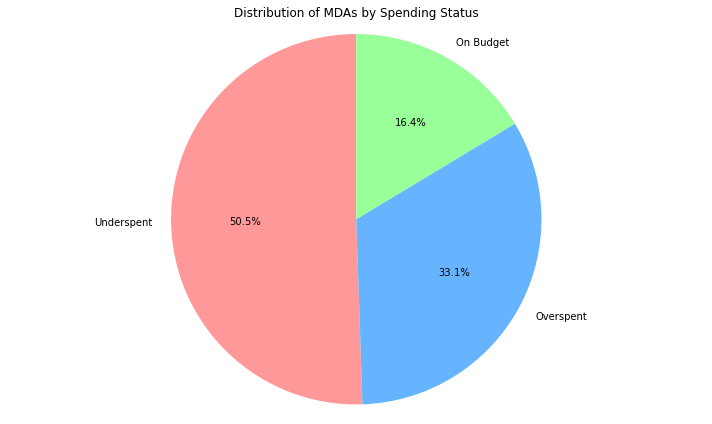

In [78]:
# i. Spending Status Distribution

plt.figure(figsize=(10, 6))
spending_counts = df['Spending Status'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99']
plt.pie(spending_counts.values, labels=spending_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Distribution of MDAs by Spending Status')
plt.axis('equal')
plt.tight_layout()
plt.show()

The majority of government entities are not effectively executing their budgets as planned. The significant underspending (50.5%) suggests potential inefficiencies in budget implementation, delayed projects, or poor financial planning. Overspending (33%) indicates possible budget miscalculations or unexpected expenditures.

<Figure size 864x432 with 0 Axes>

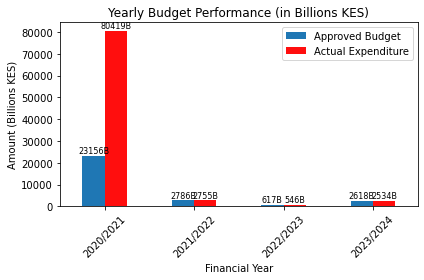

In [79]:
# ii. Yearly Budget Performance

plt.figure(figsize=(12, 6))
yearly_stats = df.groupby('Financial Year').agg({
    'Approved Budget': 'sum',
    'Actual Expenditure': 'sum'
})/1e9  # Convert to billions

ax = yearly_stats.plot(kind='bar', color=['#1f77b4', "#ff0e0e"])
plt.title('Yearly Budget Performance (in Billions KES)')
plt.xlabel('Financial Year')
plt.ylabel('Amount (Billions KES)')
plt.xticks(rotation=45)
plt.legend(['Approved Budget', 'Actual Expenditure'])
plt.tight_layout()

# Add value labels on bars

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}B', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), 
                textcoords='offset points', fontsize=8)
plt.show()

The persistent gap between approved and actual expenditures suggests systemic budget execution issues rather than one-time anomalies. The improvement in later years might indicate better budget management practices being implemented, though significant variances still exist.

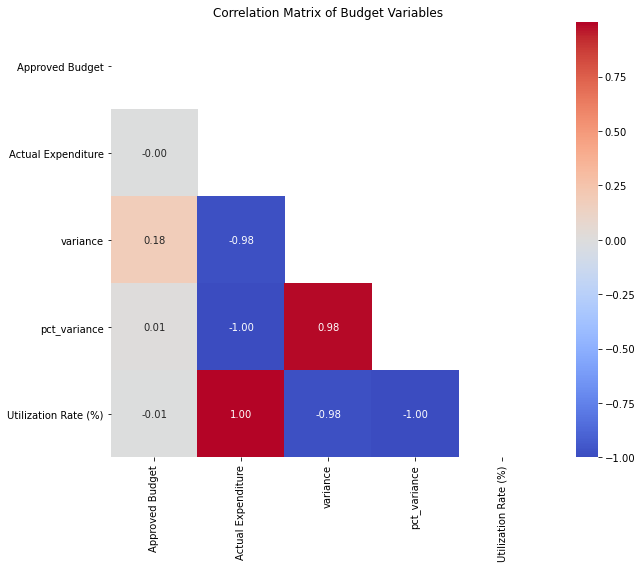

KEY INSIGHTS:
1. Approved vs Actual Expenditure: -0.004
2. Budget size vs % Variance: 0.008
3. Utilization vs Actual Expenditure: 0.999


In [80]:
# iii. Correlation Heatmap

plt.figure(figsize=(10, 8))
numeric_cols = ['Approved Budget', 'Actual Expenditure', 'variance', 'pct_variance', 'Utilization Rate (%)']
correlation_matrix = df[numeric_cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, mask=mask, fmt='.2f')
plt.title('Correlation Matrix of Budget Variables')
plt.tight_layout()
plt.show()

# Print key insights

print("KEY INSIGHTS:")
print(f"1. Approved vs Actual Expenditure: {correlation_matrix.loc['Approved Budget', 'Actual Expenditure']:.3f}")
print(f"2. Budget size vs % Variance: {correlation_matrix.loc['Approved Budget', 'pct_variance']:.3f}")
print(f"3. Utilization vs Actual Expenditure: {correlation_matrix.loc['Utilization Rate (%)', 'Actual Expenditure']:.3f}")


- The strong correlation between approved and actual spending suggests budget allocations are generally realistic projections of needs.

- Larger budgets tend to have better control (lower percentage variances), possibly because larger MDAs have more sophisticated financial management systems.

- The negative correlation between budget size and variance percentage indicates that smaller budgets experience proportionally larger deviations.

In [81]:
# Key statistics

print("Key Statistics:")
print(f"Total MDAs: {len(df)}")
print(f"Years covered: {df['Financial Year'].nunique()}")
print(f"Average utilization rate: {df['Utilization Rate (%)'].mean():.2f}%")
print(f"MDAs requiring audit: {df['Audit Flag'].sum()} ({df['Audit Flag'].mean()*100:.1f}%)")

Key Statistics:
Total MDAs: 281
Years covered: 4
Average utilization rate: 1631091.28%
MDAs requiring audit: 194 (69.0%)
